In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/playground-series-s6e2/sample_submission.csv
/kaggle/input/playground-series-s6e2/train.csv
/kaggle/input/playground-series-s6e2/test.csv


In [3]:
TRAIN_PATH = "/kaggle/input/playground-series-s6e2/train.csv"
TEST_PATH  = "/kaggle/input/playground-series-s6e2/test.csv"
SUB_PATH   = "/kaggle/input/playground-series-s6e2/sample_submission.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)
sub_df   = pd.read_csv(SUB_PATH)

In [4]:
print(train_df.shape, test_df.shape, sub_df.shape)
train_df.head()

(630000, 15) (270000, 14) (270000, 2)


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [5]:
TARGET = "Heart Disease"
ID_COL = "id";

print("Missing values in y:", train_df[TARGET].isna().sum())
# Drop rows where y is missing 
train_clean = train_df.dropna(subset=[TARGET]).copy()

#Separate features (X) and target (y)
X = train_clean.drop(columns=[TARGET,ID_COL])
X_test = test_df.drop(columns=[ID_COL])

print("X shape:", X.shape)
print("X_test shape:", X_test.shape)


Missing values in y: 0
X shape: (630000, 13)
X_test shape: (270000, 13)


## Encode target for modeling (Presence=1, Absence=0)

In [6]:
#keep for EDA / report
y_label = train_clean[TARGET].astype(str) 

#Encode target for modeling (Presence=1, Absence=0)
label_to_int = {"Absence": 0, "Presence": 1}
y = y_label.map(label_to_int)

# Safety check
if y.isna().any():
    bad = y_label[y.isna()].unique()
    raise ValueError(f"Unexpected target labels found in {TARGET}: {bad}")

y = y.astype(int)

print("y shape:", y.shape, "| y unique:", sorted(y.unique()))
print("Target labels:", y_label.unique())

y shape: (630000,) | y unique: [np.int64(0), np.int64(1)]
Target labels: ['Presence' 'Absence']


In [7]:
#Missing values summary
missing_train = X.isna().sum().sort_values(ascending=False)
missing_test  = X_test.isna().sum().sort_values(ascending=False)

print("\nTop missing (train):")
print(missing_train[missing_train > 0].head(20))

print("\nTop missing (test):")
print(missing_test[missing_test > 0].head(20))



Top missing (train):
Series([], dtype: int64)

Top missing (test):
Series([], dtype: int64)


In [8]:
#Detect numeric vs categorical columns from X
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Exploratory Data Analysis (EDA)

### 1. Target Distribution

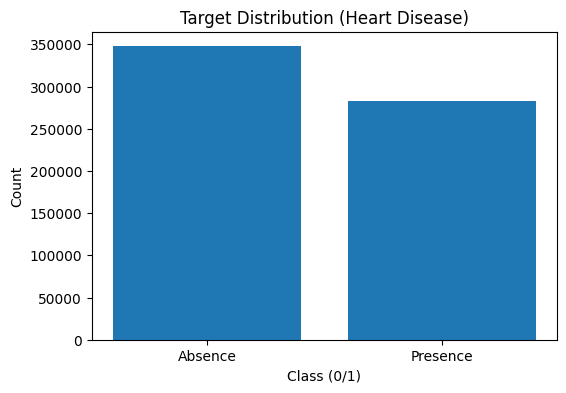

In [9]:
target_counts = train_clean[TARGET].value_counts().sort_index()
plt.figure(figsize=(6,4))
plt.bar(target_counts.index.astype(str), target_counts.values)
plt.title("Target Distribution (Heart Disease)")
plt.xlabel("Class (0/1)")
plt.ylabel("Count")
plt.show()

### 2. Missing Values Analysis

In [10]:
# 2) Missing values (Top 15) - Train & Test
def plot_missing_top(df, title, top_n=15):
    miss = df.isna().sum()
    miss = miss[miss > 0].sort_values(ascending=False).head(top_n)
    if len(miss) == 0:
        print(f'No missing values in: {title}')
        return
    plt.figure(figsize=(8, 4))
    plt.bar(miss.index.astype(str), miss.values)
    plt.xticks(rotation=60, ha='right')
    plt.title(title)
    plt.ylabel('Missing count')
    plt.tight_layout()
    plt.show()

plot_missing_top(train_df, 'Train: Top Missing Columns')
plot_missing_top(test_df,  'Test: Top Missing Columns')

No missing values in: Train: Top Missing Columns
No missing values in: Test: Top Missing Columns


### 3. Numeric Feature Distributions

In [11]:
# 3) Identify numeric vs categorical columns (excluding ID and target)
feature_cols = [c for c in train_df.columns if c not in [TARGET, ID_COL]]
num_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(train_df[c])]
cat_cols = [c for c in feature_cols if c not in num_cols]

print('Numeric cols:', len(num_cols))
print('Categorical cols:', len(cat_cols))

Numeric cols: 13
Categorical cols: 0


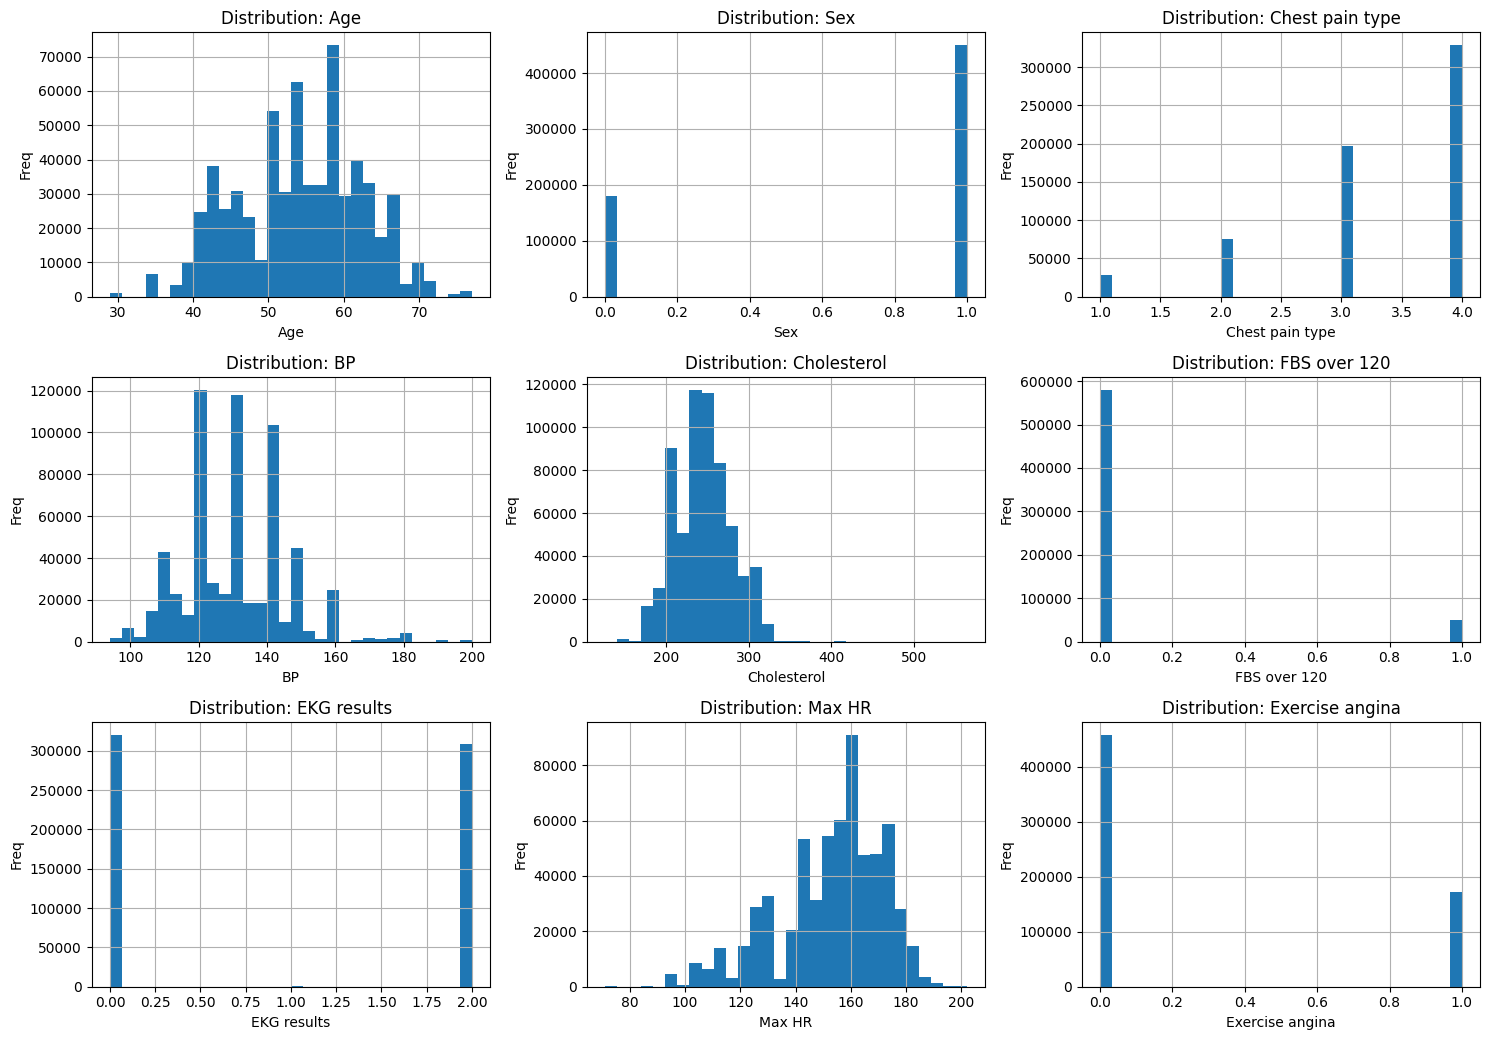

In [12]:
#Numeric distributions (Top 9 numeric columns)
top_num = num_cols[:9]
if len(top_num) > 0:
    cols = 3
    rows = math.ceil(len(top_num) / cols)
    plt.figure(figsize=(cols * 5, rows * 3.5))
    for i, c in enumerate(top_num, 1):
        ax = plt.subplot(rows, cols, i)
        train_df[c].dropna().hist(bins=30)
        ax.set_title(f'Distribution: {c}')
        ax.set_xlabel(c)
        ax.set_ylabel('Freq')
    plt.tight_layout()
    plt.show()
else:
    print('No numeric columns detected for histograms.')

### 4. Outlier Detection

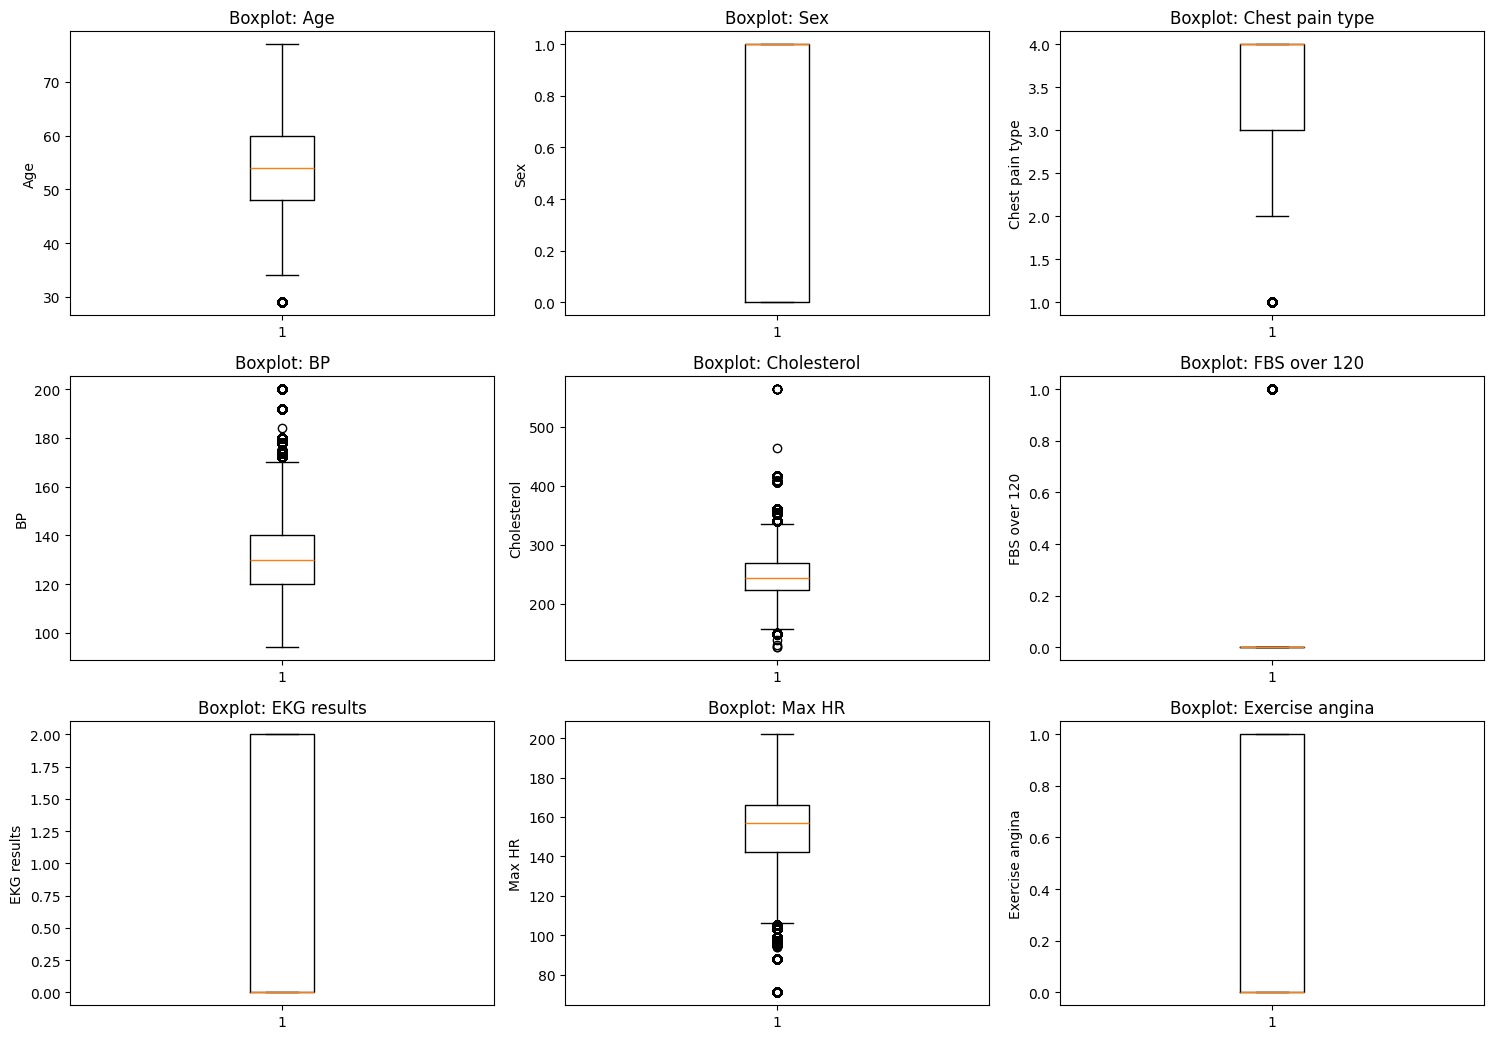

In [13]:
#Numeric outliers (boxplots - Top 9 numeric columns)
if len(top_num) > 0:
    cols = 3
    rows = math.ceil(len(top_num) / cols)
    plt.figure(figsize=(cols * 5, rows * 3.5))
    for i, c in enumerate(top_num, 1):
        ax = plt.subplot(rows, cols, i)
        data = train_df[c].dropna().values
        ax.boxplot(data, vert=True)
        ax.set_title(f'Boxplot: {c}')
        ax.set_ylabel(c)
    plt.tight_layout()
    plt.show()


### 5. Categorical Feature Frequencies

In [14]:
#Categorical frequencies (Top 4 categorical columns, top 12 categories)
top_cat = cat_cols[:4]
for c in top_cat:
    vc = train_df[c].astype(str).value_counts().head(12)
    plt.figure(figsize=(8, 4))
    plt.bar(vc.index, vc.values)
    plt.xticks(rotation=60, ha='right')
    plt.title(f'Category Frequency: {c} (Top 12)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

### 6. Correlation Analysis

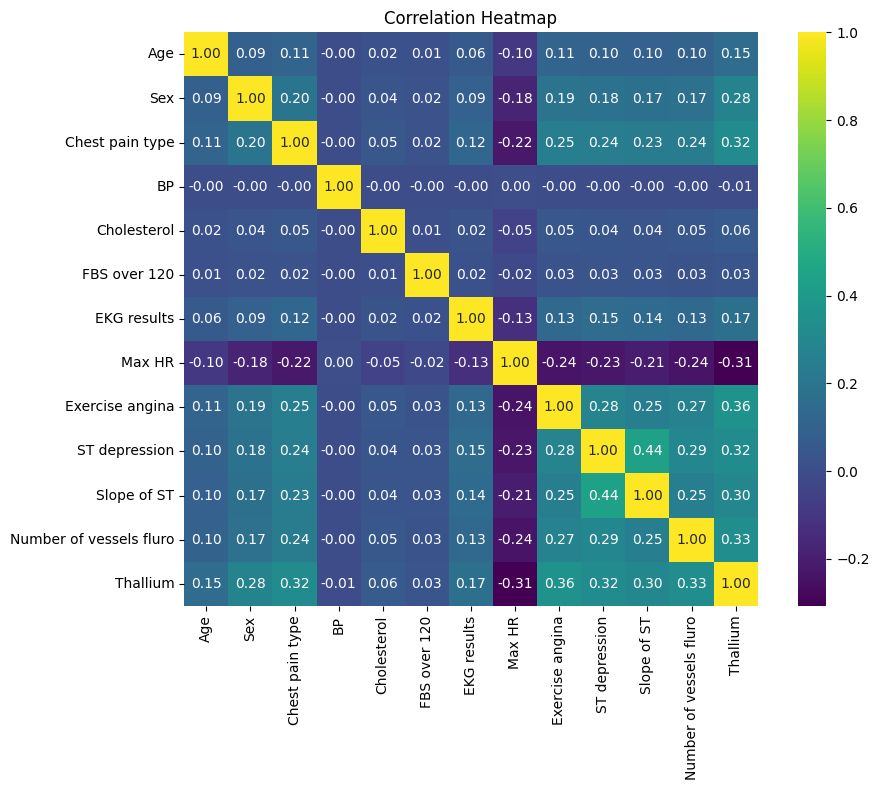

In [15]:
import seaborn as sns
if len(num_cols) > 1:
 corr = X[num_cols].corr()
    
 plt.figure(figsize=(10, 8))
 sns.heatmap(
    corr,
    annot=True,            
    fmt=".2f",          
    cmap="viridis",
    cbar=True,
    square=True
 )

 plt.title("Correlation Heatmap")
 plt.tight_layout()
 plt.show()

### 7. Numeric features vs target (binary comparison)

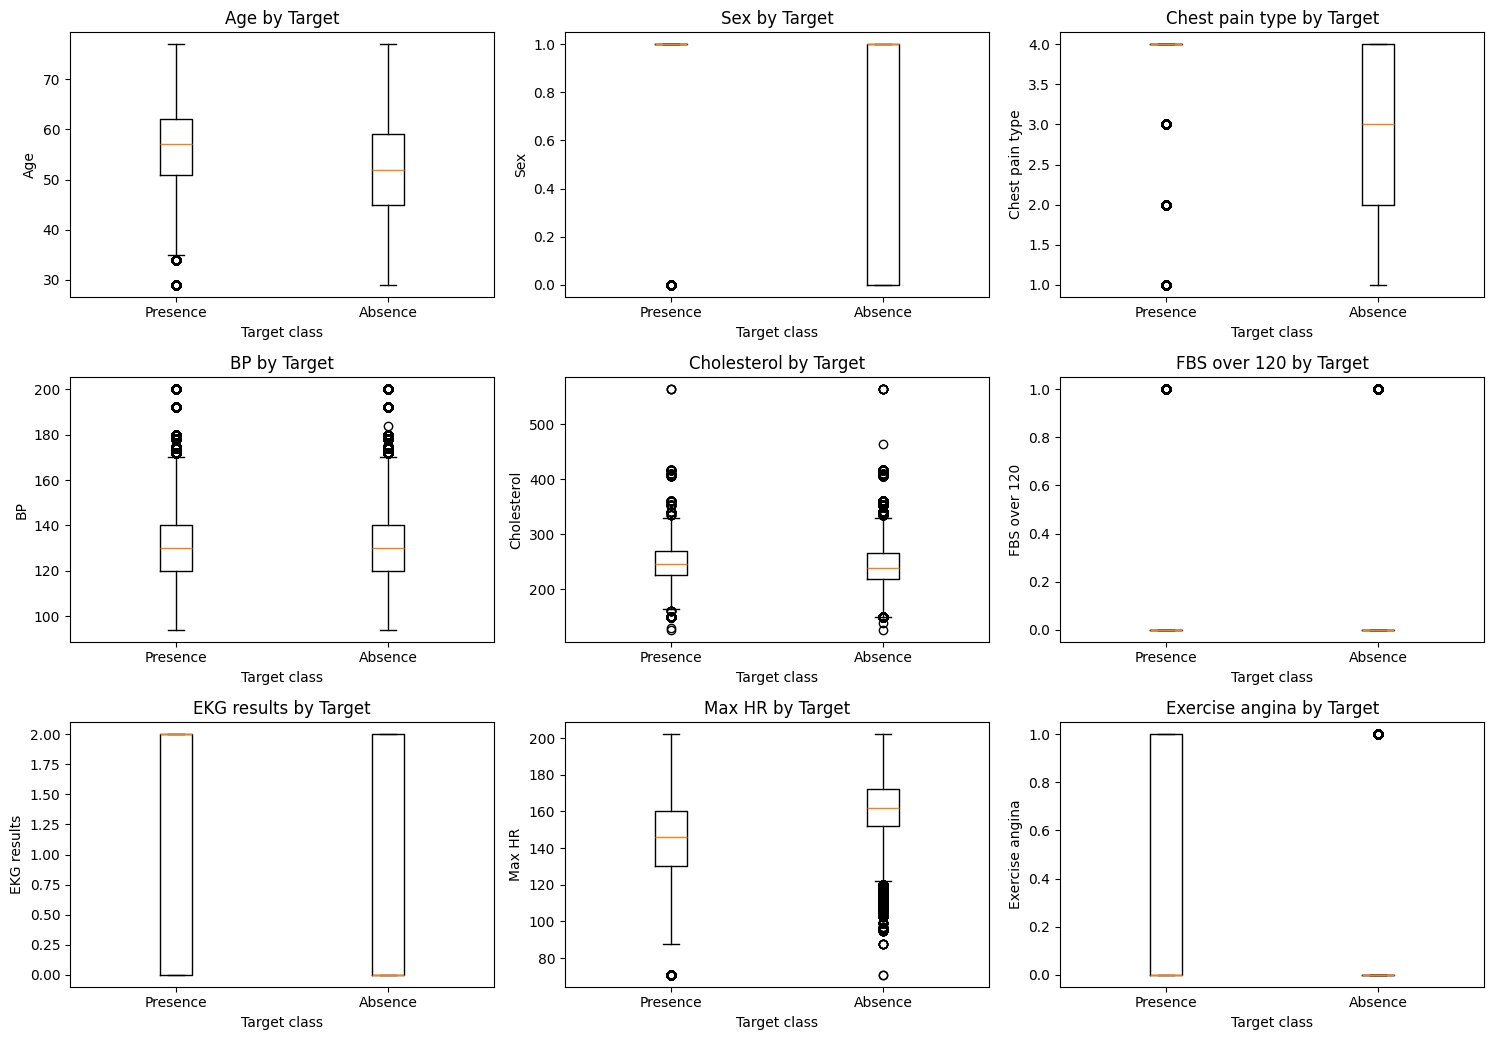

In [16]:
# 7) Feature vs Target (numeric) - compare distributions by class
# Works even if your target is encoded already (0/1). If target is strings, it will still plot.
if TARGET in train_df.columns:
    tmp = train_df[[TARGET] + top_num].copy()
    # Drop missing target rows
    tmp = tmp.dropna(subset=[TARGET])
    classes = list(pd.unique(tmp[TARGET]))
    if len(classes) == 2 and len(top_num) > 0:
        cols = 3
        rows = math.ceil(len(top_num) / cols)
        plt.figure(figsize=(cols * 5, rows * 3.5))
        for i, c in enumerate(top_num, 1):
            ax = plt.subplot(rows, cols, i)
            g0 = tmp[tmp[TARGET] == classes[0]][c].dropna().values
            g1 = tmp[tmp[TARGET] == classes[1]][c].dropna().values
            ax.boxplot([g0, g1], tick_labels=[str(classes[0]), str(classes[1])])
            ax.set_title(f'{c} by Target')
            ax.set_xlabel('Target class')
            ax.set_ylabel(c)
        plt.tight_layout()
        plt.show()
    else:
        print('Target is not binary (or no numeric cols) — skipping feature-vs-target boxplots.')
else:
    print('TARGET column not found — skipping feature-vs-target plots.')

# Preprocessor build

In [17]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

print("Numeric cols:", len(num_cols))
print("Categorical cols:", len(cat_cols))

# 2) Pipelines for each type
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

#Combine into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"
)

#Fit on train X and transform train/test
X_prepared = preprocessor.fit_transform(X)
X_test_prepared = preprocessor.transform(X_test)

print("Prepared X shape:", X_prepared.shape)
print("Prepared X_test shape:", X_test_prepared.shape)

Numeric cols: 13
Categorical cols: 0
Prepared X shape: (630000, 13)
Prepared X_test shape: (270000, 13)


# Model pipeline build

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,RocCurveDisplay

In [19]:

#Full pipeline = preprocess + model
model = LogisticRegression(max_iter=3000, solver="saga")

clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", model)
])

#Stratified K-Fold (keeps class balance)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation ROC-AUC (report credibility)

In [20]:
#ROC-AUC cross validation
scores = cross_val_score(
    clf, X, y,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1
)

print("ROC-AUC scores (5 folds):", scores)
print("Mean ROC-AUC:", scores.mean())
print("Std ROC-AUC :", scores.std())

ROC-AUC scores (5 folds): [0.94950529 0.94844948 0.94946698 0.94892613 0.94964594]
Mean ROC-AUC: 0.9491987623424955
Std ROC-AUC : 0.00044757674941431233


# Hold-out Validation block (Confusion Matrix + ROC Curve)

In [21]:

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [22]:
# Train on train-split
clf.fit(X_tr, y_tr)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age', 'Sex',
                                                   'Chest pain type', 'BP',
                                                   'Cholesterol',
                                                   'FBS over 120',
                                                   'EKG results', 'Max HR',
                                                   'Exercise angina',
                                                   'ST depression',
                                                   'Slope of ST',
                                                   'Number of vessels fluro',
                                                   'Thallium']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('model', LogisticRegression(max_iter=3000, solver='saga'))])

In [23]:
# Predict labels on validation split
y_pred = clf.predict(X_val)

In [24]:
# Optional: classification report (precision/recall/f1)
# Class names: 0=Absence, 1=Presence
print("\nClassification Report (Val):")
print(classification_report(y_val, y_pred, target_names=["Absence", "Presence"]))


Classification Report (Val):
              precision    recall  f1-score   support

     Absence       0.89      0.90      0.90     69509
    Presence       0.88      0.86      0.87     56491

    accuracy                           0.88    126000
   macro avg       0.88      0.88      0.88    126000
weighted avg       0.88      0.88      0.88    126000



In [25]:
#Confusion Matrix (numbers)
cm = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix (Val):\n", cm)


Confusion Matrix (Val):
 [[62890  6619]
 [ 8064 48427]]


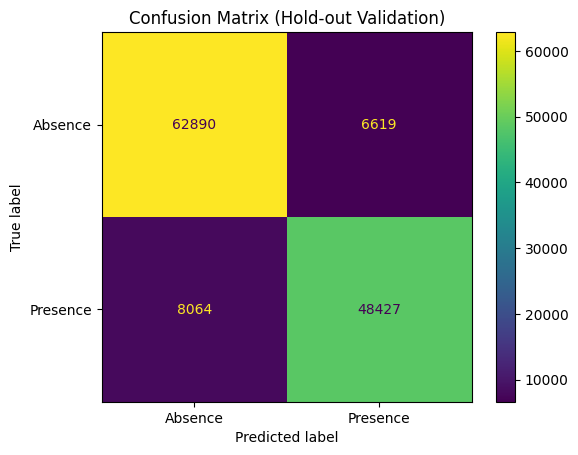

In [26]:
#Confusion Matrix (plot)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Absence", "Presence"])
disp.plot(values_format="d")
plt.title("Confusion Matrix (Hold-out Validation)")
plt.show()


In [27]:
# ---- ROC Curve (Hold-out) ----
val_probs = clf.predict_proba(X_val)[:, 1]

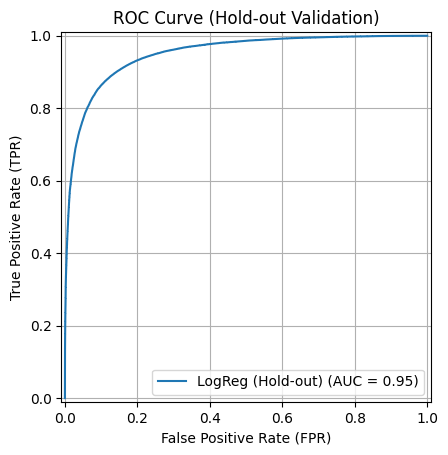

In [28]:
RocCurveDisplay.from_predictions(
    y_val,
    val_probs,
    name="LogReg (Hold-out)"
)

plt.title("ROC Curve (Hold-out Validation)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Fit on FULL data + Predict on test

In [29]:
clf.fit(X, y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age', 'Sex',
                                                   'Chest pain type', 'BP',
                                                   'Cholesterol',
                                                   'FBS over 120',
                                                   'EKG results', 'Max HR',
                                                   'Exercise angina',
                                                   'ST depression',
                                                   'Slope of ST',
                                                   'Number of vessels fluro',
                                                   'Thallium']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('model', LogisticRegression(max_iter=3000, solver='saga'))])

In [30]:
test_probs = clf.predict_proba(X_test)[:, 1]

In [31]:
from sklearn.metrics import PrecisionRecallDisplay

In [32]:
# submission column name (safe way)
pred_col = sub_df.columns[1]
sub_df[pred_col] = test_probs

In [33]:
print(sub_df.head())
print("\nPrediction min/max:", sub_df[pred_col].min(), sub_df[pred_col].max())

       id  Heart Disease
0  630000       0.966366
1  630001       0.004271
2  630002       0.993668
3  630003       0.016969
4  630004       0.126935

Prediction min/max: 0.0001909189319880904 0.9999926882466419


# Save submission.csv

In [34]:
sub_df.to_csv("submission.csv", index=False)
print("\nSaved: submission.csv")


Saved: submission.csv


# Section 2

# XGBoost model setup

In [35]:
from xgboost import XGBClassifier

In [36]:
# XGBoost model (safe baseline config)
xgb_model = XGBClassifier(
    n_estimators=4000,      #Number of boosting trees
    learning_rate=0.02,    #Step size shrinkage to prevent overfitting of one tree
    max_depth=4,           #Maximum depth of each decision tree 
    subsample=0.85,        #Use rows 85%
    colsample_bytree=0.85, #Use features 85%
    reg_lambda=1.0, 
    objective="binary:logistic", #Binary classification with logistic (probability) output
    eval_metric="auc", #Evaluation metric aligned with Kaggle competition (ROC-AUC)
    tree_method="hist",
    random_state=42, 
    n_jobs=-1 # Use all available CPU cores for faster training
)

# Pipeline = same preprocessor + XGBoost
xgb_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", xgb_model)
])

# Same CV strategy (FAIR comparison)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [37]:
# ROC-AUC cross validation
xgb_scores = cross_val_score(
    xgb_clf,
    X, y,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1
)

print("XGBoost ROC-AUC scores:", xgb_scores)
print("XGBoost Mean ROC-AUC:", xgb_scores.mean())
print("XGBoost Std ROC-AUC :", xgb_scores.std())


XGBoost ROC-AUC scores: [0.95573823 0.9546597  0.95551104 0.95511536 0.9559269 ]
XGBoost Mean ROC-AUC: 0.9553902487523237
XGBoost Std ROC-AUC : 0.00045451913980657486


In [38]:
xgb_clf.fit(X_tr, y_tr)    # XGBoost pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age', 'Sex',
                                                   'Chest pain type', 'BP',
                                                   'Cholesterol',
                                                   'FBS over 120',
                                                   'EKG results', 'Max HR',
                                                   'Exercise angina',
                                                   'ST depression',
                                                   'Slope of ST',
                                                   'Number of vessels fluro',
                                                   'Thallium']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.02,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=4000, n_jobs=-1,
                               num_parallel_tree=None, ...))])

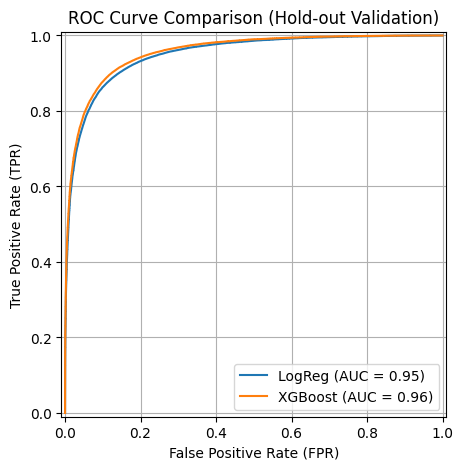

In [39]:
# 2) Get probabilities on same validation split
lr_probs  = clf.predict_proba(X_val)[:, 1]
xgb_probs = xgb_clf.predict_proba(X_val)[:, 1]

# 3) Plot both ROC curves on same figure
plt.figure(figsize=(7,5))

RocCurveDisplay.from_predictions(y_val, lr_probs,  name="LogReg", ax=plt.gca())
RocCurveDisplay.from_predictions(y_val, xgb_probs, name="XGBoost", ax=plt.gca())

plt.title("ROC Curve Comparison (Hold-out Validation)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [40]:
test_probs = xgb_clf.predict_proba(X_test)[:, 1]

pred_col = sub_df.columns[1]
sub_df[pred_col] = test_probs

sub_df.to_csv("submission-finalize-V1.csv", index=False)
print("Saved: submission-finalize-V1.csv")
print(sub_df.head())
print("Prediction min/max:", sub_df[pred_col].min(), sub_df[pred_col].max())

Saved: submission-finalize-V1.csv
       id  Heart Disease
0  630000       0.957783
1  630001       0.009604
2  630002       0.986831
3  630003       0.006001
4  630004       0.183696
Prediction min/max: 0.0001302768214372918 0.9999440908432007


# Final Model Training + Save Pipeline (Deployment)

In [41]:
import joblib

# 1) Train FINAL model on full dataset
xgb_clf.fit(X, y)

# 2) Save the whole pipeline (preprocess + model) as one file
joblib.dump(xgb_clf, "final_xgb_pipeline.joblib")

print("Saved: final_xgb_pipeline.joblib")

Saved: final_xgb_pipeline.joblib


In [42]:
list(X.columns)

['Age',
 'Sex',
 'Chest pain type',
 'BP',
 'Cholesterol',
 'FBS over 120',
 'EKG results',
 'Max HR',
 'Exercise angina',
 'ST depression',
 'Slope of ST',
 'Number of vessels fluro',
 'Thallium']

In [43]:
import sklearn, xgboost, joblib, numpy, pandas
print("sklearn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("joblib:", joblib.__version__)
print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)

sklearn: 1.6.1
xgboost: 3.1.0
joblib: 1.5.3
numpy: 2.0.2
pandas: 2.2.2


In [44]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
